### Gillespie algorithm for simulating kinesin walking on microtubules in vitro
MK Iwanski 2020-04-07

In [1]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
import os.path as os

In [2]:
# function for debugging
def pause():
    programPause = input('Press <ENTER> to continue.')

In [29]:
# parameters
mt_length = 100
nstep = 10**4

#rates of reactions
k_fwd = 180 #0.1 #steps per sec
k_bck = 0 #steps per sec
k_on = 1 #0.00002 #per dimer per sec
k_off = 20 #0.005 #per sec

#update vectors for each reaction
nu_fwd = -1
nu_bck = -1
nu_on = 1
nu_off = -1

#update affinities of mt sites
alpha_max = 5 #0.00003 #maximal change in k_on (at site of motor)
decay_lambda = 10**(100) # 1/(falls to 1/e in how much time) [sec]
decay_dist = 1 #falls to 1/e in how many dimers [dimers]
#TO DO: assume this drops exponentially with number of sites away from motor and with time

In [30]:
def gillespie(X, t, m): #update time and state vectors (mt and affinity at site m)
   
    #generate random numbers
    rt = np.random.random()
    rr = np.random.random()
    
    #time to next reaction
    tau = np.log(1/rt)/k_tot
    
    #determine which reaction
    j = 0
    test = k[0]/k_tot
    while test<rr and j<len(k):#-1:
        j += 1
        test += k[j]/k_tot

    #pause()
    
    t += tau #update time
    X[m] += nu[j] #update state
    if j == 0:
        if m < mt_length-1 and X[m+1] == 0:
            X[m+1] -= nu[j] #update state of +1 site for forward step
        #if it can't move forward, don't do anything
    if j == 1:
        if m >  0 and X[m-1] == 0:
             X[m-1] -= nu[j] #update state of -1 site for back step
        #if it can't move backward, don't do anything
    
    return X, t

In [31]:
def find_closest_motor(lattice_site, motors):
    assert isinstance(lattice_site,int)
    
    motors = np.asarray(motors)
    idx = (np.abs(motors - lattice_site)).argmin()
    return motors[0,idx] 
    #pause()
    
    #idx = 0
    #min_dist = abs(lattice_site-motors[idx])
    #for k in range(0,motors.shape[1]):
    #    motor = motors[0,k] #int(motors[0,k])
    #    #pause()
        
    #    distance = abs(lattice_site-motor)
    #    if distance < min_dist:
    #        idx = motor
    #        min_dist = distance
    ##idx = distance.cdist([lattice_site], motors).argmin()
    #return motors[0,idx]

In [32]:
def affinity_update(aff, X, t_step): #update affinity based on motor positions
    decay_aff = aff*np.exp(-decay_lambda*t_step) #affinities decay with time (back to baseline)
    
    #aff = aff*np.exp(-t_step) #affinities decay with time back to baseline
    
    aff[X==1] = alpha_max #affinity at motor positions increase to max value
    
    motors = np.asarray(np.where(X==1), dtype=np.int)
    motors.flatten()
    
    #for k in range(0,motors.shape[1]):
    #    motor_loc = motors[0,k]
    #    #pause()
    #    for j in range(0,mt_length):
    #        if (motor_loc+j)<(mt_length-1):
    #            aff[motor_loc+j] += alpha_max*np.exp(-j)
    #        if (motor_loc-j)>=0:
    #            aff[motor_loc-j] += alpha_max*np.exp(-j)
    #    #TO DO: How to deal with overlapping effects...?

    #pause()
    if motors.size != 0:
        for j in range(0,mt_length):
            #for each lattice site, find closest motor
            closest_motor = find_closest_motor(j,motors)
            distance_from_site = int(np.abs(closest_motor-j))

            aff[j] += alpha_max*np.exp(-distance_from_site/decay_dist) #update affinity based on closest motor
    
    for j in range(0,mt_length):
        if aff[j] < decay_aff[j]:
            aff[j] = decay_aff[j]
    
    aff[aff<k_on] = k_on #set back to baseline if below
    aff[aff>alpha_max] = alpha_max
    
    return aff

In [33]:
#initialize
mt = np.zeros((nstep,mt_length), dtype=np.int)
affinity = np.zeros((nstep,mt_length))
affinity[:] = k_on
t = np.zeros(nstep)

#place motor(s) on MT to begin
for i in range(0,1):
    mt[0,np.random.randint(0,mt_length)] = 1

In [34]:
#run Gillespie
for i in range(0,nstep-1):
    #choose MT lattice site
    m = np.random.randint(0,mt_length)
    #check current possible reactions
    if mt[i,m] == 1: #site is occupied
        k = [k_fwd, k_bck, 0, k_off]
        k_tot = np.sum(k)
        nu = [nu_fwd, nu_bck, 0, nu_off]
    else: #site is empty
        k = [0, 0, affinity[i,m], k_off] #k = [0, 0, k_on, k_off]
        k_tot = np.sum(k)
        nu = [0, 0, nu_on, 0]
        
    mt[i+1,:],t[i+1] = gillespie(mt[i,:],t[i],m)
    affinity[i+1,:] = affinity_update(affinity[i,:],mt[i+1,:],(t[i+1]-t[i]))
#pause() 

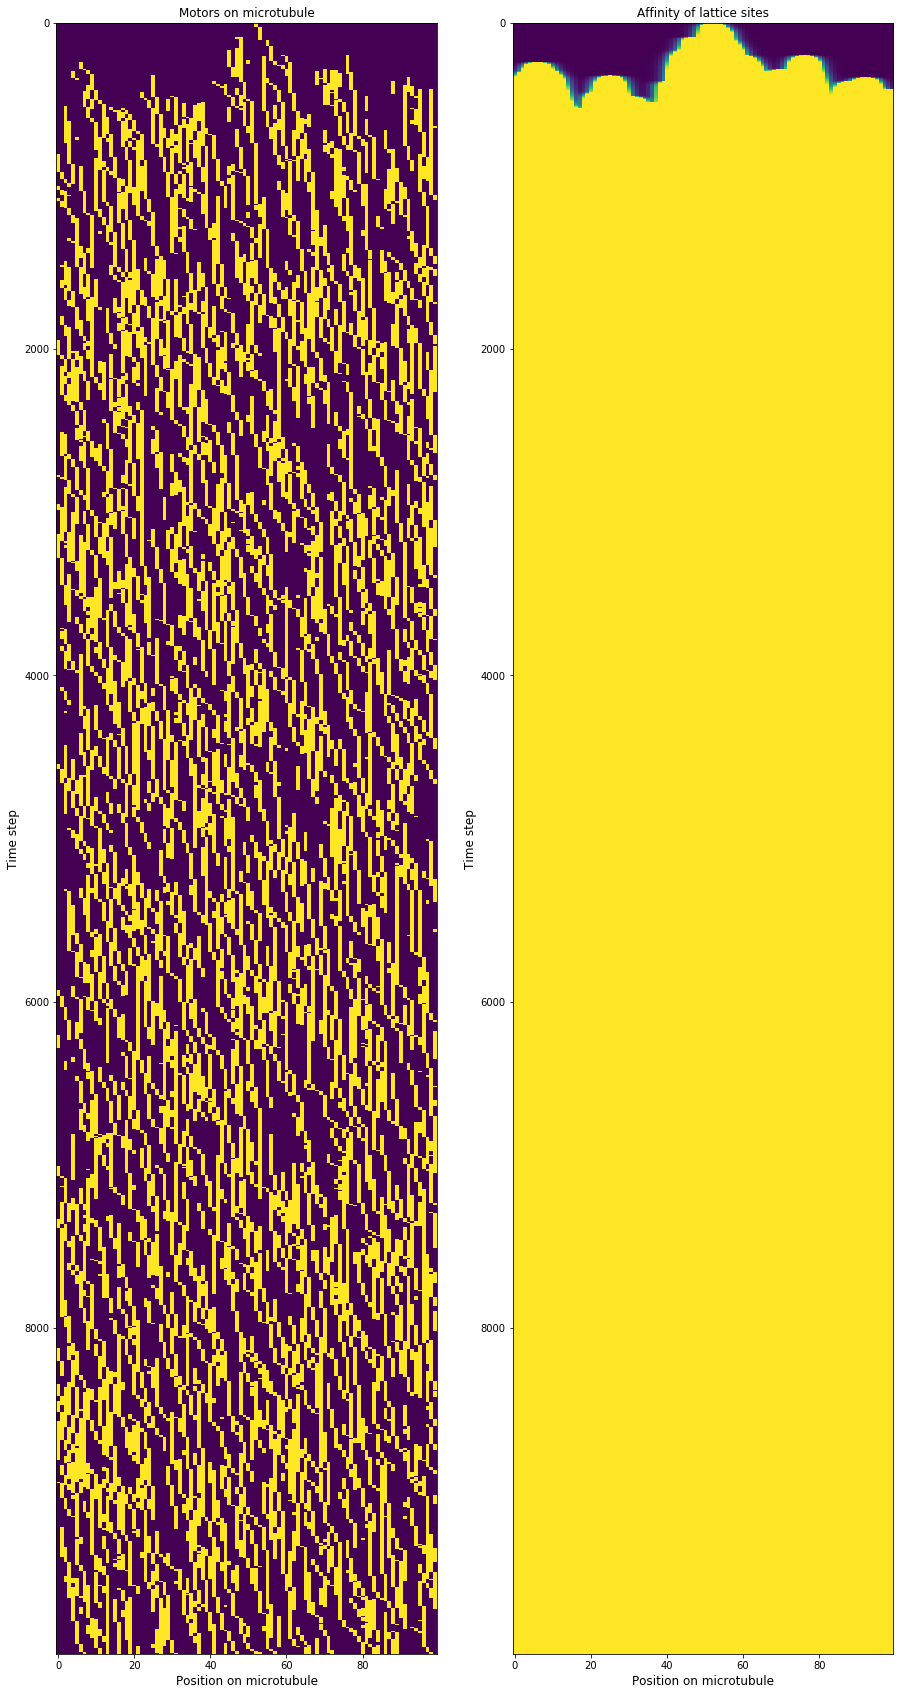

In [35]:
# plot results
fig, ax = plt.subplots(1,2, figsize=(15, 30))

ax[0].imshow(mt, cmap='viridis', aspect='auto', interpolation='nearest')
ax[0].set_title("Motors on microtubule", fontsize=12)
ax[0].set_ylabel("Time step", fontsize=12)
ax[0].set_xlabel("Position on microtubule", fontsize=12)

ax[1].imshow(affinity, cmap='viridis', aspect='auto', interpolation='nearest')
ax[1].set_title("Affinity of lattice sites", fontsize=12)
ax[1].set_ylabel("Time step", fontsize=12)
ax[1].set_xlabel("Position on microtubule", fontsize=12)

plt.show()

In [76]:
print(t[-1])

1860064.2894939804


In [38]:
# save figs
save_dir = 'OneDrive - Universiteit Utrecht/Python/Temp_Figures/'
save_fname = 'Simulation_2020-04-07.png'
save_path = os.join(save_dir,save_fname)
plt.savefig(save_fname,format='png')

<Figure size 432x288 with 0 Axes>